# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

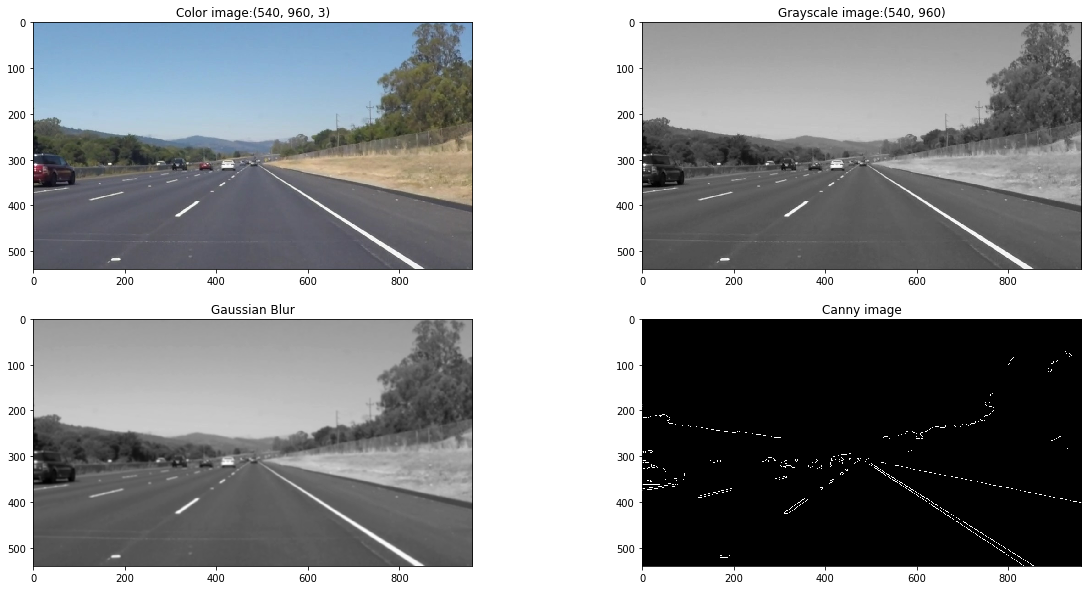

In [2]:
#reading in an image
test_image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
#print('This image is:', type(image), 'with dimensions:', image.shape)
#plt.imshow(image)  

# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
#print('This image is:', type(gray), 'with dimensions:', gray.shape)

f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(221)
ax1.set_title('Color image:' + str(test_image.shape))
plt.imshow(test_image)
ax2 = f.add_subplot(222)
ax2.set_title('Grayscale image:'+ str(test_gray.shape))
plt.imshow(test_gray, cmap='gray')

test_gaussian_blur = cv2.GaussianBlur(test_gray, (7, 7), 0)
ax3 = f.add_subplot(223)
ax3.set_title('Gaussian Blur')
plt.imshow(test_gaussian_blur, cmap='gray')

test_canny=cv2.Canny(test_gaussian_blur, 100, 150)
ax4 = f.add_subplot(224)
ax4.set_title('Canny image')
plt.imshow(test_canny, cmap='gray')


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math
from scipy import stats

'Grayscale transform'
def grayscale(img):
    '''This will return an image with only one color channel.
    #To see the returned image as grayscale you should call plt.imshow(image, cmap='gray')'''
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Or use BGR2GRAY if you read an image with cv2.imread()

'Gaussian Noise kernel'   #Hint choose kernel size as odd number
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

'Canny transform'  #Hint: low to high ratio  1:2 or 1:3'
def canny_edges(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

'Image mask - Only keeps the region of the image defined by the polygon formed from `vertices`.'
def region_of_interest(img, vertices):
    '''The rest of the image is set to black. 
    `vertices` should be a numpy array of integer points.'''
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

'separate lines into left and right lanes'
def partition_lines(lines):
    l_lines=[]
    r_lines=[]
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if (x2-x1) == 0:
                break

            slope = (y2-y1)/(x2-x1)

            if slope < 0 and max(x1,x2) < 500:
                l_lines.append(line)
            elif slope > 0 and max(x1,x2) > 460:
                r_lines.append(line)

    return l_lines, r_lines

'take a weighted average of slopes and intercepts'
def weighted_line(lines):
    slopes=[]
    intercepts=[]
    weights=[]
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2-y1)/(x2-x1)
            slopes.append(slope)
            intercepts.append(y1-slope*x1)
            weights.append(math.sqrt((x2-x1)**2 + (y2-y1)**2))

    m = np.sum(np.array(weights)*np.array(slopes))/np.sum(weights)
    b = np.sum(np.array(weights)*np.array(intercepts))/np.sum(weights)

    return m, b, weights

'use linear regression to find slopes and intercepts'
def linear_regression(lines):
    x=[]
    y=[]
    
    for line in lines:
        [(x.append(x1), x.append(x2), y.append(y1), y.append(y2)) for x1, y1, x2, y2 in line]
    
    if x==[] or y==[]:
        return None, None
    else:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        return slope, intercept

'draw straight lines from raw hough lines data'
def draw_lines1(img, lines, color=[255, 0, 0], thickness=2):
    img_copy=np.copy(img)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (x2-x1) == 0:
                break
            else:    
                slope = (y2-y1)/(x2-x1)
                if slope < 0:   # left side
                    cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)
                else:           # right side
                    cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)
                    
    return img_copy

'draw straight left and right lines extrapolated using linear regression'

def draw_lines2(img, lines, color=[255, 0, 0], thickness=10):
    img_copy=np.copy(img)

    l_lines, r_lines = partition_lines(lines)
    y1=540  # bottom of image
    y2=320  # top of region
        
    if l_lines==[]:   # skip if image is blank or has no hough lines
        plt.imshow(img)
        pass
    else:
        lslope, lintercept =  linear_regression(l_lines)   #y = (slope)x + intercept
        x1 = int((y1-lintercept)/lslope)
        x2 = int((y2-lintercept)/lslope)
        cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)

    if r_lines==[]:   # skip if image is blank or has no hough lines
        plt.imshow(img)
        pass
    else:
        rslope, rintercept =  linear_regression(r_lines)   #y = (slope)x + intercept
        x1 = int((y1-rintercept)/rslope)
        x2 = int((y2-rintercept)/rslope)
        cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)
        
    return img_copy

'draw straight left and right lines extrapolated using weighted averages of slopes and intercepts'
def draw_lines3(img, lines, color=[255, 0, 0], thickness=10):
    img_copy=np.copy(img)

    y1=540  # bottom of image
    y2=320  # top of region
    
    slope=[]
    intercept=[]
    l_lines, r_lines = partition_lines(lines)
    
    if l_lines==[]:     # skip if image is blank or has no hough lines
        plt.imshow(img)
        pass
    else:
        slope, intercept, weights =  weighted_line(l_lines)   #y = (slope)x + intercept
        x1 = int((y1-intercept)/slope)
        x2 = int((y2-intercept)/slope)
        cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)
        
    if r_lines==[]:    # skip if image is blank or has no hough lines
        plt.imshow(img)
        pass
    else:
        slope, intercept, weights =  weighted_line(r_lines)   #y = (slope)x + intercept
        x1 = int((y1-intercept)/slope)
        x2 = int((y2-intercept)/slope)
        cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)
        
    return img_copy

'Compute Line Images from Hough Lines'
def line_image(img, lines, method=1):
    blank_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    if method==1:                                     # actual lines
        line_img = draw_lines1(blank_img, lines)
    elif method==2:                                   # extrapolate using linear regression
        line_img = draw_lines2(blank_img, lines)
    elif method==3:                                   # extrapolate using weighted line
        line_img = draw_lines3(blank_img, lines)
    else:                                             # return blank_img with no lines
        line_img=blank_img
    return line_img

'Probalistic Hough Transform + straight lines on blank image using method 1=actuals, 2=linear regression, or 3=weighted averages'
def hough_linesP(img, rho, theta, threshold, min_line_len, max_line_gap, method=1):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = line_image(img, lines, method)
    return line_img

'Weighted Avg of two images: initial_img * α + img * β + γ'
def weighted_img(img, initial_img, α=0.5, β=0.5, γ=0.):
    """ 
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    `initial_img` should be the image before any processing.
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

'plot list of images in subplots'
def plot_images(images, labels, cols=1):
    rows = len(images)//cols

    f = plt.figure(figsize=(20,10))
    for i, image in enumerate(images):
        ax = f.add_subplot(rows, cols, i+1)
        ax.set_title(names[i]+str(image.shape))
        plt.imshow(image, cmap='gray')

    plt.tight_layout()
    plt.show()


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

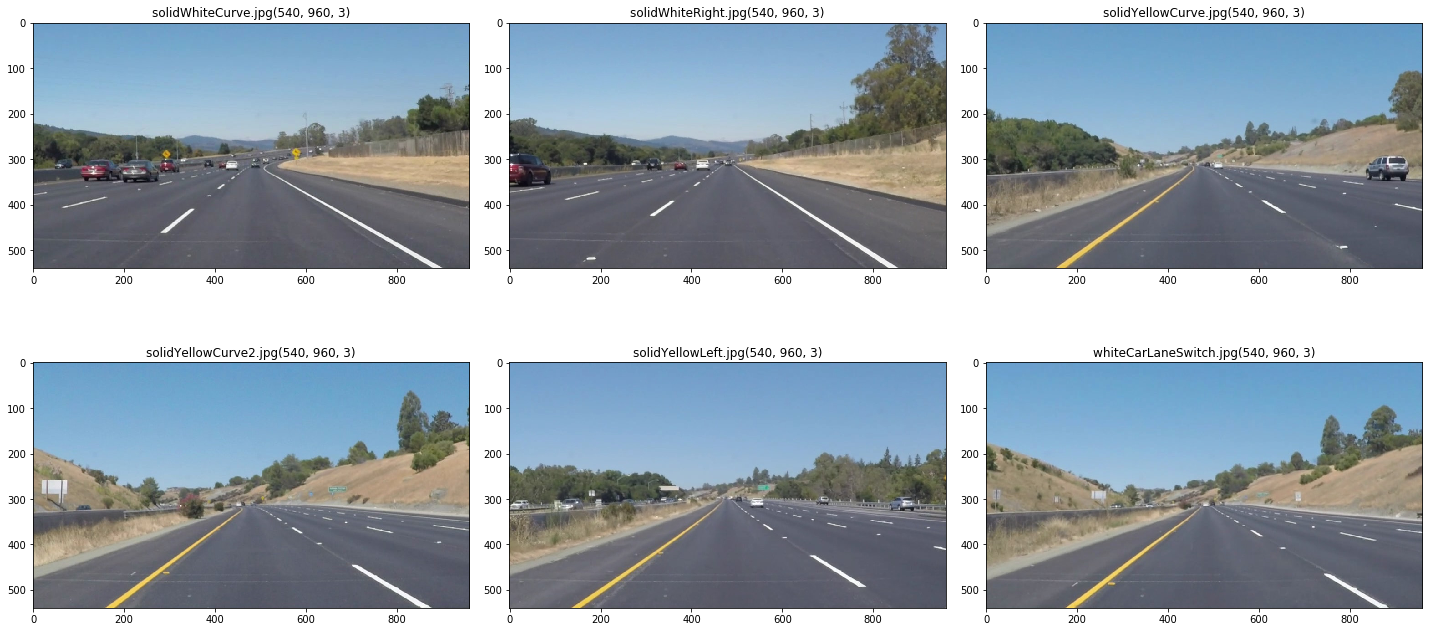

In [4]:
import os
names = os.listdir("test_images/")
images = list(map(lambda image: mpimg.imread("test_images/"+image), names))
plot_images(images, names, cols=3)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

test images


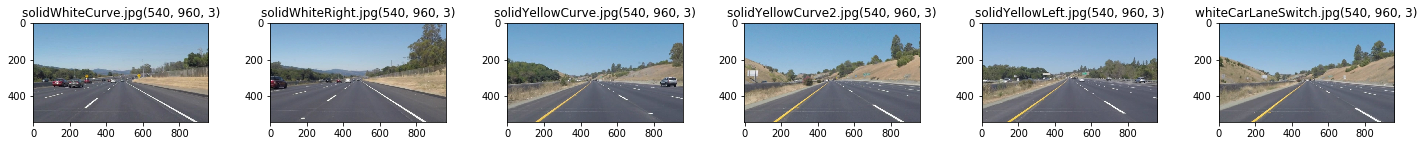

convert to grayscale


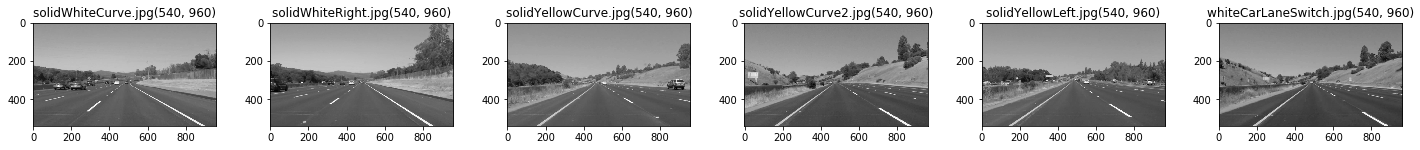

convert with gaussian blur


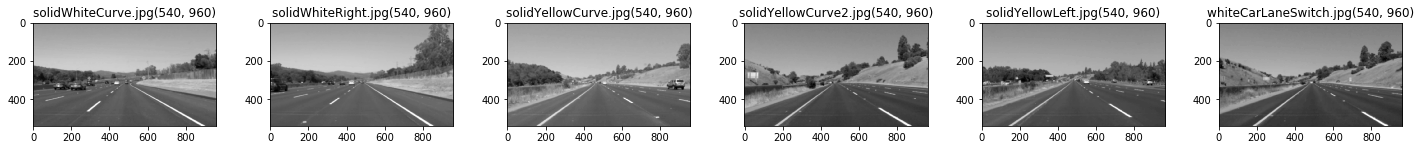

convert to canny edges


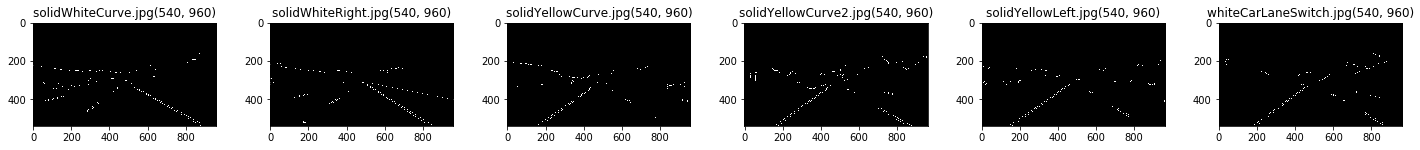

create masked images


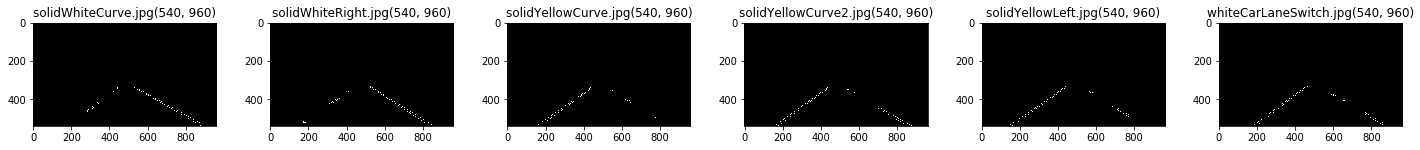

create hough lines & draw lines using raw data


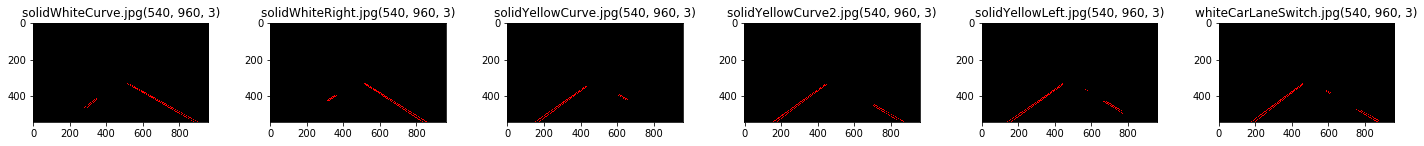

overlay raw lines with original image  α Img1 + β * Img2 + γ


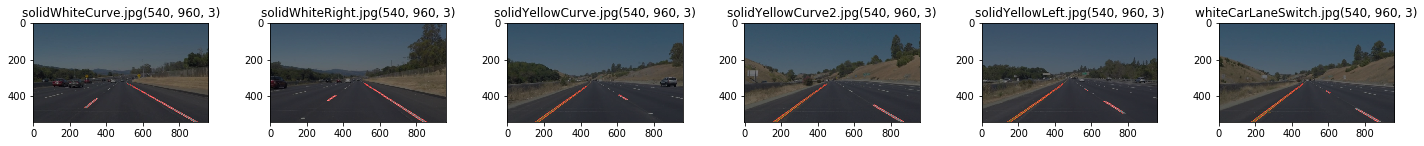

create hough lines & draw extrapolated lines using linear regression


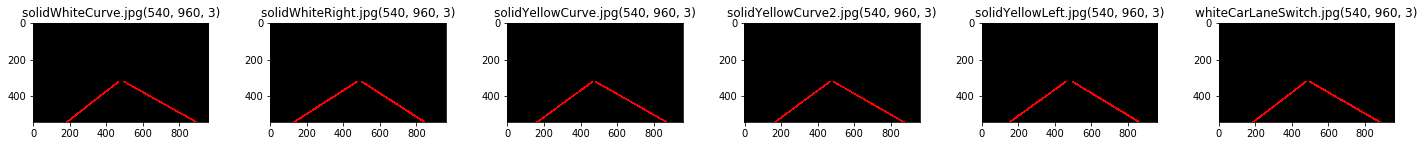

overlay lines extrapolated (linear regression) with original image  α Img1 + β * Img2 + γ


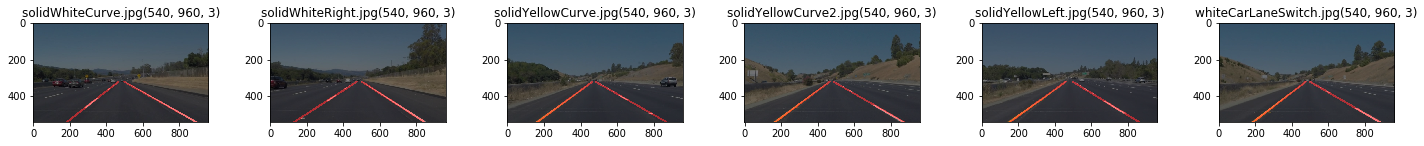

create hough lines & draw extrapolated lines using weighted averages


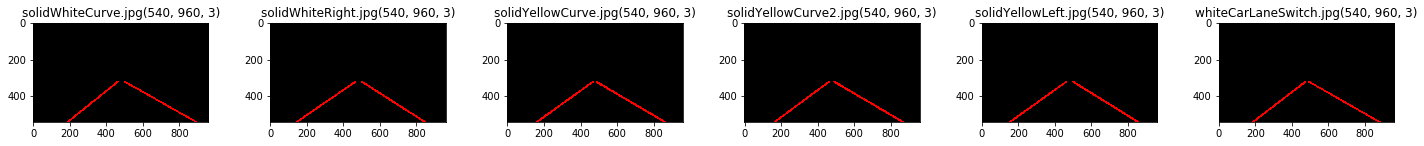

overlay lines extrapolated (weighted averages) with original image  α Img1 + β * Img2 + γ


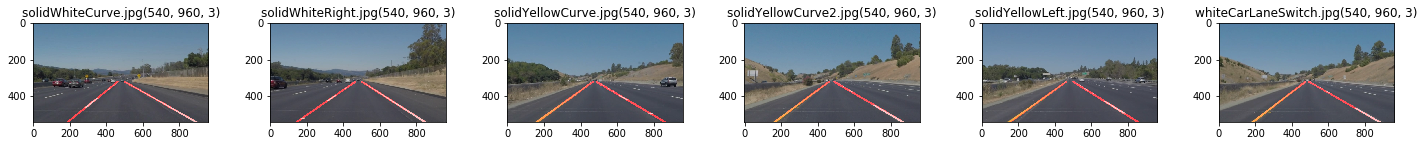

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
import os

cols=6

path = "test_images/"
names = os.listdir(path)

print ('test images')
images = list(map(lambda image: mpimg.imread(path+image), names))
plot_images(images, names, cols)

print ('convert to grayscale')
gray_images = list(map(grayscale, images))
plot_images(gray_images, names, cols)

print ('convert with gaussian blur')
blurred_images = list(map(lambda img: gaussian_blur(img, kernel_size=11), gray_images))
plot_images(blurred_images, names, cols)

print ('convert to canny edges')
canny_images = list(map(lambda img: canny_edges(img, low_threshold=75, high_threshold=150), blurred_images))
plot_images(canny_images, names, cols)

print ('create masked images')
vertices = np.array([[(100,540), (430,330), (540,330), (920,540)]], dtype=np.int)
masked_images = list(map(lambda img: region_of_interest(img, vertices), canny_images))
plot_images(masked_images, names, cols)

rho=1
theta=np.pi/180
threshold=30 
min_line_len=15
max_line_gap=5

print ('create hough lines & draw lines using raw data')
line_images = list(map(lambda img: hough_linesP(img, rho, theta, threshold, min_line_len, max_line_gap, method=1), masked_images))
plot_images(line_images, names, cols)

print ('overlay raw lines with original image  α Img1 + β * Img2 + γ')
overlay_images = [weighted_img(img, initial_img, α=0.5, β=0.5, γ=0.) for img, initial_img in list(zip(line_images, images))]
plot_images(overlay_images, names, cols)

print ('create hough lines & draw extrapolated lines using linear regression')
line_images = list(map(lambda img: hough_linesP(img, rho, theta, threshold, min_line_len, max_line_gap, method=2), masked_images))
plot_images(line_images, names, cols)

print ('overlay lines extrapolated (linear regression) with original image  α Img1 + β * Img2 + γ')
overlay_images = [weighted_img(img, initial_img, α=0.5, β=0.5, γ=0.) for img, initial_img in list(zip(line_images, images))]
plot_images(overlay_images, names, cols)

print ('create hough lines & draw extrapolated lines using weighted averages')
line_images = list(map(lambda img: hough_linesP(img, rho, theta, threshold, min_line_len, max_line_gap, method=3), masked_images))
plot_images(line_images, names, cols)

print ('overlay lines extrapolated (weighted averages) with original image  α Img1 + β * Img2 + γ')
overlay_images = [weighted_img(img, initial_img, α=0.8, β=1.0, γ=0.) for img, initial_img in list(zip(line_images, images))]
plot_images(overlay_images, names, cols)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    global i
    i+=1
    to_print=True
    print_path = 'test_video_output_frames/' + str(i)
        
    'convert to grayscale'
    gray_image = grayscale(image)

    'convert with gaussian blur'
    blurred_image = gaussian_blur(gray_image, kernel_size=5)

    'convert to canny edges'
    canny_image = canny_edges(blurred_image, low_threshold=50, high_threshold=150)

    'create masked images'
    vertices = np.array([[(100,540), (430,330), (540,330), (920,540)]], dtype=np.int)
    masked_image = region_of_interest(canny_image, vertices)

    'create hough lines'
    line_img = hough_linesP(masked_image, rho=1, theta=np.pi/180, threshold=30, min_line_len=15, max_line_gap=5, method=3)

    'overlay lines with original image  α Img1 + β * Img2 + γ'
    overlay_image = weighted_img(line_img, image, α=0.5, β=0.5, γ=0.)
    
    'save video frames with processing to disk'
    if to_print and i<10: 
        mpimg.imsave(print_path + '_1_image.jpg', image)
        mpimg.imsave(print_path + '_2_gray_image.jpg', gray_image)
        mpimg.imsave(print_path + '_3_blurred_image.jpg', blurred_image)
        mpimg.imsave(print_path + '_4_canny_image.jpg', canny_image)
        mpimg.imsave(print_path + '_5_masked_image.jpg', masked_image)
        mpimg.imsave(print_path + '_6_line_img.jpg', line_img)
        mpimg.imsave(print_path + '_7_overlay_image.jpg', overlay_image)        
        
    return overlay_image

'use to overlay region of interest with video'
def process_image2(image):
    vertices = np.array([[(100,540), (430,330), (540,330), (920,540)]], dtype=np.int)
    masked_image = region_of_interest(image, vertices)
    return masked_image


Let's try the one with the solid white lane on the right first ...

In [13]:
i=0
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

'video output'
white_output = 'test_videos_output/solidWhiteRight.mp4'
white_clip = clip1.fl_image(process_image)                #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

'video output with just region of interest'
white_output_region = 'test_videos_output/solidWhiteRight_region.mp4'
#white_clip = clip1.fl_image(process_image2)
#%time white_clip.write_videofile(white_output_region, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:08<00:00, 25.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 8.81 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
i=0
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)

'video output'
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

'video output with just region of interest'
yellow_output_region = 'test_videos_output/solidYellowLeft_region.mp4'
#yellow_clip = clip2.fl_image(process_image2)    #show movie with region of interest
#%time yellow_clip.write_videofile(yellow_output_region, audio=False)


[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:07<00:00, 90.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 7.77 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
i=0
clip3 = VideoFileClip('test_videos/challenge.mp4')
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)

'video output'
#challenge_output = 'test_videos_output/challenge.mp4'
#challenge_clip = clip3.fl_image(process_image)
#%time challenge_clip.write_videofile(challenge_output, audio=False)

def process_image3(image):
    vertices = np.array([[(140,720), (560,450), (740,450), (1220,720)]], dtype=np.int)    
    masked_image = region_of_interest(image, vertices)
    return masked_image

'video output with just region of interest'
challenge_output_region = 'test_videos_output/challenge_region.mp4'
challenge_clip = clip3.fl_image(process_image3)
%time challenge_clip.write_videofile(challenge_output_region, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output_region))